# Embedding to non-euclidean spaces with MAP

MAP (Manifold Approximation and Projection) is a lighter version of [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html).

While UMAP learns a low-dimensional graph layout by minimizing the cross-entropy between a fuzzy simplicial set and an initialization, MAP only uses the cross-entropy minimization. The graph construction is conveniently done by TopOMetry on top of the eigenvectors of Laplacian-type operators, allowing it to rely on a looser manifold hypothesis (e.g., not necessarily uniform).

For visualization purposes, data is usually embedded to a 2D euclidean plane. However, new studies involving single-cell data analysis have pointed to the utility of performing non-euclidean embeddings ([1](https://doi.org/10.1038/s41467-020-16822-4),[2](https://doi.org/10.1038/s41467-021-22851-4)). The key idea is we can embed data to any given space, such as spheres, hyperboloids and so on.

Here, we show how to perform these embeddings within TopOMetry. Please note this heavily derives from [on previous work on UMAP](https://umap-learn.readthedocs.io/en/latest/embedding_space.html). The only differences here are making it more user-friendly and focusing on single-cell data.

To start we’ll load the usual selection of libraries.

In [1]:
import scanpy as sc
import topo as tp
%matplotlib inline

As a test dataset we’ll use 3k PBMCs from a Healthy Donor from 10X Genomics available in Scanpy and [here.](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

In [2]:
adata = sc.datasets.pbmc3k_processed()

After loading the data and QC, instead using PCA for linear dimensional reduction, we can use the TopOGraph to make a diffusion-based dimensional reduction to get the topological metrics that we gonna use on the graphs. 

In [3]:
# Start up the TopOGraph
tg = tp.TopOGraph(n_jobs=-1)

# Run a couple of models
tg.run_models(adata.X, kernels=['bw_adaptive'],
                   eigenmap_methods=['DM'],
                   projections=['MAP'])

Computing neighborhood graph...
 Base kNN graph computed in 0.471962 (sec)
 Fitted the bw_adaptive kernel in 0.288316 (sec)
Computing eigenbasis...
 Fitted eigenbasis with Diffusion Maps from the bw_adaptive kernel in 1.218856 (sec)
    Building topological graph from eigenbasis...
        Computing neighborhood graph...
 Computed in 0.061567 (sec)
 Fitted the bw_adaptive graph kernel in 0.352005 (sec)
 Computed MAP in 8.383925 (sec)


Now we need to find the clusters. Here we clustering with leiden

In [4]:
sc.tl.leiden(adata, adjacency=tg.graph_kernel.P)

In [5]:
labels = adata.obs['leiden'].astype('int')

## Euclidean: 2- and 3-D 

This is the standard ploting option for printed material such as manuscripts and research articles. TopOMetry has a plotting module that can be used to visualize this data:

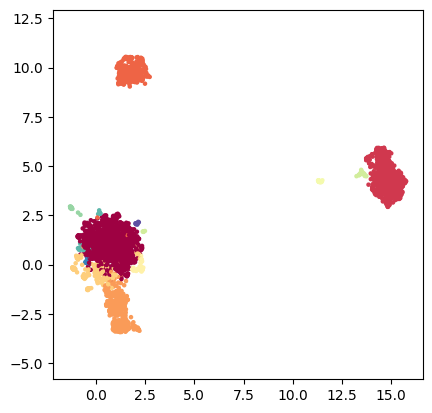

In [6]:
tp.pl.scatter(tg.ProjectionDict['MAP of bw_adaptive from DM with bw_adaptive'], labels=labels)

TopOMetry can also plot data onto 3 dimensions. When using the 'TkAgg' matplotlib backend users can interactively explore them. For this, we'll need to compute a new initialisation, with 3 dimensions.

 Computed MAP in 6.841442 (sec)


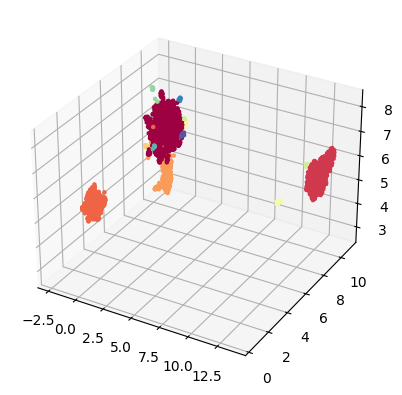

In [7]:
tridim_emb = tg.project(projection_method='MAP', n_components=3)

tp.pl.scatter3d(tridim_emb, labels=labels)

Naturally, we can also use plotly to visualize the results:



In [8]:
!pip3 install plotly

Defaulting to user installation because normal site-packages is not writeable


In [9]:
import plotly.express as px 

fig = px.scatter_3d(tridim_emb, x=0, y=1, z=2, size_max=5, 
symbol=labels.astype('str'), color=labels.astype('str'))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## Spherical embeddings


Here we project the lower dimensional embedding into a spheric space. 

 Computed MAP in 7.313364 (sec)


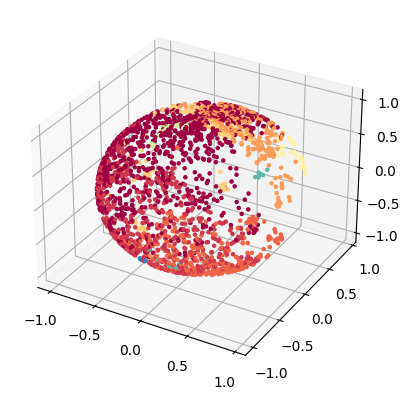

In [10]:
sphere_emb = tg.project(projection_method='MAP', n_components=2, output_metric='haversine')

tp.pl.sphere(sphere_emb, labels=labels)

Or its planar projection:

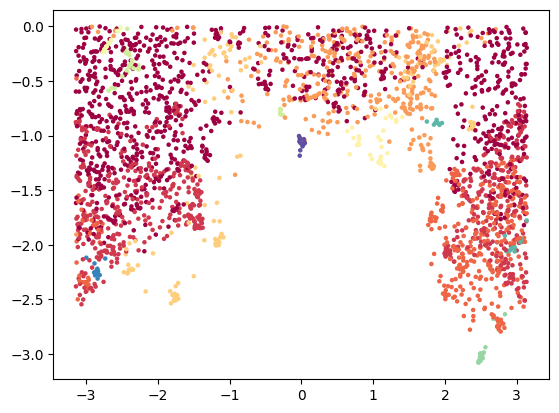

In [11]:
tp.pl.sphere_projection(sphere_emb, labels=labels)

We can also try to plot this with plotly:

In [12]:
import numpy as np
import pandas as pd

x = np.sin(sphere_emb[:, 0]) * np.cos(sphere_emb[:, 1])
y = np.sin(sphere_emb[:, 0]) * np.sin(sphere_emb[:, 1])
z = np.cos(sphere_emb[:, 0])

df = pd.DataFrame({'x': x, 'y': y, 'z': z, 'labels': labels.astype('str')})

fig = px.scatter_3d(df, x=x, y=y, z=z, size_max=5, 
symbol=labels.astype('str'), color=labels.astype('str'))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## Torus embedding

TopOMetry allows you to vizualize your data as a donut, using for this the torus embedding. Torus is a surface of revolution generated by revolving a circle in three-dimensional space about an axis. See more details [here](https://en.wikipedia.org/wiki/Torus)

 Computed MAP in 8.235361 (sec)


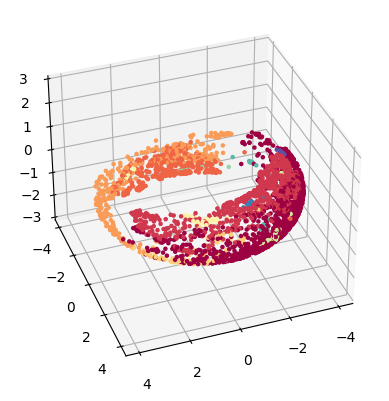

In [13]:
torus_emb = tg.project(projection_method='MAP', n_components=2, output_metric='torus')

tp.pl.toroid(torus_emb, labels=labels)

## Hyperboloid embedding


On data science, it is common to use hyperbolic representations for hierarchical data (see more context [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6534139/)). We can use the [hyperboloid model](https://en.wikipedia.org/wiki/Hyperboloid_model) on TopOMetry to see our data in this space:

 Computed MAP in 7.213238 (sec)


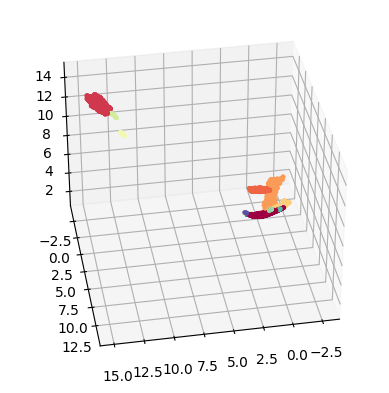

In [14]:
hyper_emb = tg.project(projection_method='MAP', n_components=2, output_metric='hyperboloid')

tp.pl.hyperboloid(hyper_emb, labels=labels)

We can also try to visualize this data with plotly:

In [15]:
x,y,z = tp.pl.two_to_3d_hyperboloid(hyper_emb)

df = pd.DataFrame({'x': x, 'y': y, 'z': z, 'labels': labels.astype('str')})

fig = px.scatter_3d(df, x=x, y=y, z=z, size_max=3,
symbol=labels.astype('str'), color=labels.astype('str'))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

Usually, we use [Poincare’s disk model](https://en.wikipedia.org/wiki/Poincar%C3%A9_disk_model) for this visualization of a hyperbolic space.

 Computed MAP in 7.289338 (sec)


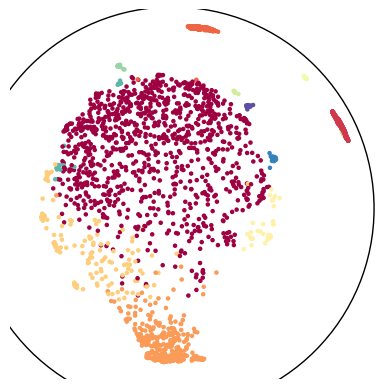

In [16]:
poincare_emb = tg.project(projection_method='MAP', n_components=2, output_metric='poincare')

tp.pl.poincare(poincare_emb, labels=labels)

## Gaussian-Energy Embedding

Unlike most approaches that represent nodes as point vectors in a low-dimensional continuous space, each one with exact values for every parameter, we can embed each node as a Gaussian distribution and infers a probability distribution over all possible values, allowing us to capture uncertainty about the representation. See more context [here](https://doi.org/10.1371/journal.pcbi.1008186) and [here](https://arxiv.org/abs/1707.03815v4)

 Computed MAP in 6.930510 (sec)


/home/davi/.local/lib/python3.10/site-packages/topo/plot.py:213: RuntimeWarning:

invalid value encountered in sqrt



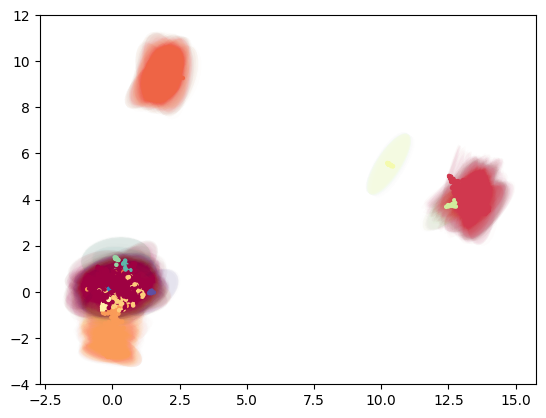

In [17]:
gauss_emb = tg.project(projection_method='MAP', n_components=5, output_metric='gaussian_energy')

tp.pl.gaussian_potential(gauss_emb, labels=labels)

### That was it for this tutorial!

So now you know how to use the various possible output metrics of MAP (because of UMAP) to visualize your single-cell data!